In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline

In [3]:
%autoreload

In [4]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [5]:
import pandas as pd
import flora_tools.lwb_slot as lwb_slot
from flora_tools.lwb_slot import LWBSlot

payloads = [8, 16, 32, 64, 128, 255]

payload_strings = [str(i) for i in payloads]

## Ack Slot Formula

#### Glossy without adaptions:

$$ E_\mathrm{Total} = N \cdot r \cdot (E_\mathrm{Rx} + E_\mathrm{Tx}) - E_\mathrm{Rx} $$

$$ E_\mathrm{Total} = N \cdot r \cdot (\frac{N \cdot r - 1}{N \cdot r} E_\mathrm{Rx} + E_\mathrm{Tx}) $$

where $r$ is the retransmission rate and $N$ is the number of nodes. The preamble detection power is not accounted for.

#### Glossy with ACK

Given 

$$ E_\mathrm{Rx,Ack} = \alpha \cdot E_\mathrm{Rx} $$

and

$$ E_\mathrm{Tx,Ack} = \alpha \cdot E_\mathrm{Tx} $$

and assuming that all packages receive their destined nodes at the first chance. The acknowledgement is only resent once after its reception.

We consider each node $n_i$ by itself. The crucial term for describing when a node $n_i$ is interrupted by the Ack is given by the difference in arrival time of the source's package and the destination's Ack ($l$ for latency):

$$ l(n_i) = \max(0, (d(n_\text{src}, n_\text{dst}) - 1) + \max(d(n_\text{dst}, n_i), 1) - (d(n_\text{src}, n_i) - 1)) \\
= \max(0, d(n_\text{src}, n_\text{dst}) + \max(d(n_\text{dst}, n_i), 1) - d(n_\text{src}, n_i))$$

The upper bound total slot count can be approximated by

$$ |S_{\mathrm{Rx}_{n_i}}| = \min(\text{ceil}(\frac{l(n_i)}{2}), r) $$

$$ |S_{\mathrm{Tx}_{n_i}}| = \text{floor}(\frac{l(n_i)}{2}) $$

$$ |S_{\mathrm{Tx,Ack}_{n_i}}| = H( 2 \cdot r - l(n_i) - 1) $$

$$ |S_{\mathrm{Rx,Ack}_{n_i}}| = H( 2 \cdot r - l(n_i) - 2) $$

where $H(n_i)$ is the Heaviside function.

Special adaptions for a better approximation are the source node itself which has one Rx slot less and therefore has to be regarded seperately in the summation. If a node has a precessor which was acked directly after a Rx slot, the regarding child node will save one Rx slot.


$$ E_\mathrm{Total} = \sum_{n_i} ( |S_{\mathrm{Rx}_{n_i}}| \cdot E_\mathrm{Rx}\\
+ |S_{\mathrm{Tx}_{n_i}}| \cdot E_\mathrm{Tx}\\
+ |S_{\mathrm{Rx,Ack}_{n_i}}| \cdot E_\mathrm{Rx,Ack}\\
+ |S_{\mathrm{Tx,Ack}_{n_i}}| \cdot E_\mathrm{Tx,Ack} )\\
- E_\mathrm{Rx}$$


##### Complete Graph Topology (best case)

Every node reaches every other node in one hop.

$$ E_\mathrm{Total} = E_\mathrm{Tx} + (N - 1) \cdot E_\mathrm{Rx} + E_\mathrm{Tx-Ack} + (N - 1) \cdot E_\mathrm{Rx-Ack}\\
= (1 + \alpha) \cdot E_\mathrm{Tx} + (1 + \alpha) \cdot (N - 1) \cdot E_\mathrm{Rx}$$

##### No reception of ACK (worst case)

The target node receives the message, but its Acknowledgement does not get received by any node. All other $N - 1$ nodes therefore retransmit the package wastefuly.

$$ E_\mathrm{Total} = (N - 1) \cdot r \cdot (E_\mathrm{Rx} + E_\mathrm{Tx} + 2 \cdot E_\mathrm{Ack_\mathrm{Rx}}) - (E_\mathrm{Rx} + E_\mathrm{Ack_\mathrm{Rx}})\\
+ (E_\mathrm{Rx} + E_\mathrm{Ack_\mathrm{Tx}}) $$

$$ = (N - 1) \cdot r \cdot ((1 + 2\alpha - \frac{\alpha}{(N-1)r}) \cdot E_\mathrm{Rx} + (1 + \frac{\alpha}{(N-1)r}) \cdot E_\mathrm{Tx}) $$

For high node counts, worst case and vanilla Glossy converge, with the Acknowledgements having $2\alpha$ overhead.

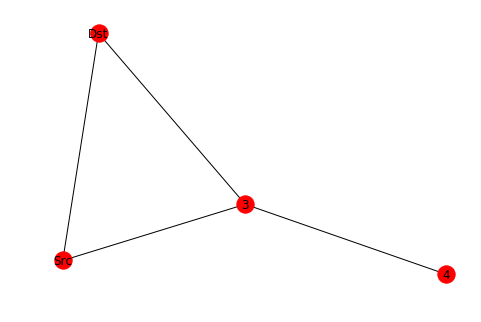

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

plt.figure()

G.add_nodes_from(["Src", "Dst", "3", "4"])
G.add_edges_from([("Src", "Dst"), ("Src", "3"), ("Dst", "3"), ("3", "4")])

nx.draw(G, with_labels=True)

plt.show()

Node 4 will not require a Rx slot.

In [7]:
columns = ["Gloria Modulation"]
columns.extend(payload_strings)

lwb_slot_time = pd.DataFrame(columns=columns)

for i in range(len(lwb_slot.MODULATIONS)):
    item = [lwb_slot.MODULATIONS[i]]
    for j in payloads:
        slot = LWBSlot.create_empty_slot(i, payload=j, acked=False)
        
        total_time = slot.total_time
        
        item.append(total_time)
    lwb_slot_time.loc[i] = item

lwb_slot_time.style


,Gloria Modulation,8,16,32,64,128,255
0,3,0.145186,0.186146,0.268066,0.411426,0.698146,1.27159
1,5,0.16797,0.22941,0.31133,0.49565,0.88477,1.62205
2,7,0.0732281,0.0924281,0.130828,0.214028,0.380428,0.706828
3,9,0.0128403,0.0144403,0.0176403,0.0240403,0.0368403,0.0622403


In [8]:
to_timer_ticks = lambda x: int(x * 8E6)

lwb_slot_time.applymap(to_timer_ticks)

,Gloria Modulation,8,16,32,64,128,255
0,24000000,1161488,1489168,2144528,3291408,5585168,10172688
1,40000000,1343758,1835278,2490638,3965198,7078158,12976398
2,56000000,585824,739424,1046624,1712224,3043424,5654624
3,72000000,102722,115522,141122,192322,294722,497922


### Gloria Flood Energy

In [9]:
lwb_slot_energy = pd.DataFrame(columns=columns)

for i in range(len(lwb_slot.MODULATIONS)):
    item = [lwb_slot.MODULATIONS[i]]
    for j in payloads:
        slot = LWBSlot.create_empty_slot(i, payload=j, acked=False)
        gloria_flood_energy = slot.flood.energy
        
        item.append(gloria_flood_energy)
    lwb_slot_energy.loc[i] = item

lwb_slot_energy.style

,Gloria Modulation,8,16,32,64,128,255
0,3,2.74896,3.49238,4.97923,7.58122,12.7852,23.1931
1,5,3.488,4.90195,6.78722,11.0291,19.9841,36.9516
2,7,1.51765,1.94083,2.7872,4.621,8.2886,15.4827
3,9,0.237979,0.273245,0.343775,0.484837,0.76696,1.3268


In [10]:
lwb_slot_energy_per_byte = lwb_slot_energy
battery_energy = 12000 * 3600 * 3.7 # 12'000 mAh

for i in range(len(lwb_slot.MODULATIONS)):
    for j in payloads:
        lwb_slot_energy_per_byte.loc[i,str(j)] /= j

battery_energy / lwb_slot_energy_per_byte

,Gloria Modulation,8,16,32,64,128,255
0,5.328000e+07,4.651651e+08,7.322907e+08,1.027243e+09,1.349356e+09,1.600252e+09,1.757383e+09
1,3.196800e+07,3.666056e+08,5.217187e+08,7.536042e+08,9.275259e+08,1.023789e+09,1.103044e+09
2,2.283429e+07,8.425661e+08,1.317702e+09,1.835130e+09,2.213754e+09,2.468393e+09,2.632559e+09
3,1.776000e+07,5.373238e+09,9.359520e+09,1.487855e+10,2.109938e+10,2.667613e+10,3.071999e+10


## ~ 28 GB of data (FSK 200 kBit/s, 255 Bytes, 12000 mAh @ 3.7 Volts, 10mW TX)

32 Byte datapoint:

In [15]:
battery_energy / lwb_slot_energy_per_byte / 100 / 32

,Gloria Modulation,8,16,32,64,128,255
0,16650.000000,1.453641e+05,2.288409e+05,3.210134e+05,4.216738e+05,5.000789e+05,5.491823e+05
1,9990.000000,1.145642e+05,1.630371e+05,2.355013e+05,2.898518e+05,3.199340e+05,3.447013e+05
2,7135.714286,2.633019e+05,4.117818e+05,5.734783e+05,6.917982e+05,7.713729e+05,8.226746e+05
3,5550.000000,1.679137e+06,2.924850e+06,4.649546e+06,6.593557e+06,8.336291e+06,9.599997e+06


### Speed

In [12]:
lwb_slot_bitrate = pd.DataFrame(columns=columns)

for i in range(len(lwb_slot.MODULATIONS)):
    item = [lwb_slot.MODULATIONS[i]]
    for j in payloads:
        slot = LWBSlot.create_empty_slot(i, payload=j, acked=False)
        gloria_flood_bitrate = slot.flood.bitrate
        
        item.append(gloria_flood_bitrate)
    lwb_slot_bitrate.loc[i] = item

lwb_slot_bitrate.style

,Gloria Modulation,8,16,32,64,128,255
0,3,440.814,687.632,954.988,1244.45,1466.74,1604.3
1,5,381.021,557.953,822.279,1032.99,1157.36,1257.67
2,7,873.981,1384.86,1956.77,2392.21,2691.7,2886.13
3,9,4984.32,8864.11,14512.3,21297.6,27795.7,32776.2


## Gloria Slot + Gloria ACK Timings

In [13]:
columns = ["Gloria Modulation"]
columns.extend(payload_strings)

lwb_slot_time = pd.DataFrame(columns=columns)

for i in range(len(lwb_slot.MODULATIONS)):
    item = [lwb_slot.MODULATIONS[i]]
    for j in payloads:
        slot = LWBSlot.create_empty_slot(i, payload=j, acked=True)
        
        total_time = slot.total_time
        
        item.append(total_time)
    lwb_slot_time.loc[i] = item

lwb_slot_time.style


,Gloria Modulation,8,16,32,64,128,255
0,3,0.151065,0.192025,0.273945,0.417305,0.704025,1.27746
1,5,0.281355,0.342795,0.424715,0.609035,0.998155,1.73544
2,7,0.1162,0.1354,0.1738,0.257,0.4234,0.7498
3,9,0.0199804,0.0215804,0.0247804,0.0311804,0.0439804,0.0693804


In [14]:
to_timer_ticks = lambda x: int(x * 8E6)

lwb_slot_time.applymap(to_timer_ticks)

,Gloria Modulation,8,16,32,64,128,255
0,24000000,1208516,1536196,2191556,3338436,5632196,10219716
1,40000000,2250842,2742362,3397722,4872282,7985242,13883482
2,56000000,929603,1083203,1390403,2056003,3387203,5998403
3,72000000,159843,172643,198243,249443,351843,555043
